In [11]:
import os
from itertools import cycle
import cx14
import cx14_data
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# %load_ext autoreload
# %autoreload 2

In [73]:
img_dir = '/home/tstrebel/assets/chest-xray-14/images/images'
target_dir = '/home/tstrebel/repos/umich-mads-capstone-project/assets/cx14-targets.csv'

training_data_target_dict = cx14_data.get_training_data_target_dict(target_dir)
df_test = training_data_target_dict['df_test']
del(training_data_target_dict)

bbox_df = pd.read_csv(os.path.join(target_dir, 'BBox_List_2017.csv')).iloc[:, 0:6]
bbox_df.columns = ['file_name', 'target', 'x', 'y', 'w', 'h']

In [4]:
test_dataset = cx14_data.CX14Dataset(img_dir, df_test)
test_dataloader = cx14_data.get_data_loader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
model = cx14.Densenet121.load_from_checkpoint('/home/tstrebel/models/cx14/best-v2.3.ckpt').cuda()

In [6]:
with torch.no_grad():
    running_targets = torch.empty((0, 1), dtype=torch.long).cuda()
    running_outputs = torch.torch.empty((0, 15)).cuda()
    
    model.eval()
    
    for inputs, targets in test_dataloader:
        inputs = inputs.cuda()
        targets = targets.cuda()
        
        outputs = model(inputs)
        
        running_targets = torch.vstack((running_targets, targets))
        running_outputs = torch.vstack((running_outputs, outputs))

accuracy:		0.6839
f1 (macro):		0.0693
f1 (micro):		0.6839
recall (macro):		0.0768
recall (micro):		0.6839
precision (macro):	0.0852
precision (micro):	0.6839


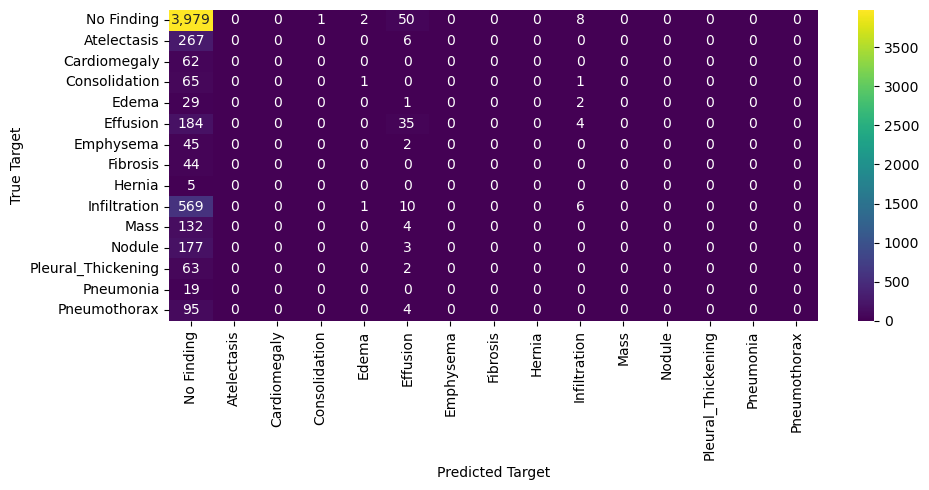

In [7]:
from sklearn import metrics

y_true = running_targets.cpu().detach().numpy()
y_pred = running_outputs.argmax(dim=1).cpu().detach().numpy()

accuracy_score = metrics.accuracy_score(y_true, y_pred)
f1_score_macro = metrics.f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro', zero_division=0)
recall_score_macro = metrics.recall_score(y_true, y_pred, average='macro', zero_division=0)
recall_score_micro = metrics.recall_score(y_true, y_pred, average='micro', zero_division=0)
precision_score_macro = metrics.precision_score(y_true, y_pred, average='macro', zero_division=0)
precision_score_micro = metrics.precision_score(y_true, y_pred, average='micro', zero_division=0)

print('accuracy:\t\t{:.4f}'.format(accuracy_score))
print('f1 (macro):\t\t{:.4f}'.format(f1_score_macro))
print('f1 (micro):\t\t{:.4f}'.format(f1_score_micro))
print('recall (macro):\t\t{:.4f}'.format(recall_score_macro)) 
print('recall (micro):\t\t{:.4f}'.format(recall_score_micro))
print('precision (macro):\t{:.4f}'.format(precision_score_macro))
print('precision (micro):\t{:.4f}'.format(precision_score_micro))

cf_matrix = metrics.confusion_matrix(y_true, y_pred)
fig = plt.figure(dpi=100, figsize=(10,5))
sns.heatmap(cf_matrix, annot=True, fmt=',', cmap='viridis', xticklabels=target_map, yticklabels=target_map)
plt.xlabel('Predicted Target')
plt.ylabel('True Target')
fig.tight_layout()
plt.show()

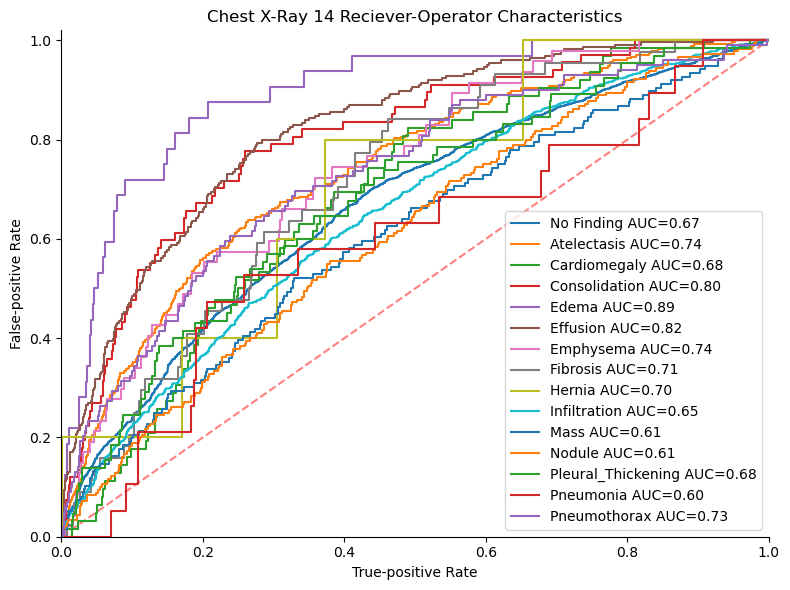

In [8]:
y_true = torch.nn.functional.one_hot(running_targets, num_classes=15).cpu().detach().squeeze().numpy()
y_pred = torch.nn.functional.softmax(running_outputs.cpu(), dim=1).detach().numpy()

scale_factor = 1.25

fig = plt.figure(dpi=100, 
                 figsize=(6.4*scale_factor, 4.8*scale_factor))

no_skill = np.linspace(0, 1, 100)
plt.plot(no_skill, no_skill, 'r--', alpha=.5)

for i, target in enumerate(target_map):
    tpr, fpr, _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    auc = metrics.roc_auc_score(y_true[:, i], y_pred[:, i])
    plt.plot(tpr, fpr, label=f'{target} AUC={auc:.2f}')
    
    
plt.xlim(0, 1)
plt.ylim(0, 1.02)

plt.title('Chest X-Ray 14 Reciever-Operator Characteristics')
plt.xlabel('True-positive Rate')
plt.ylabel('False-positive Rate')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
fig.tight_layout()
plt.show()

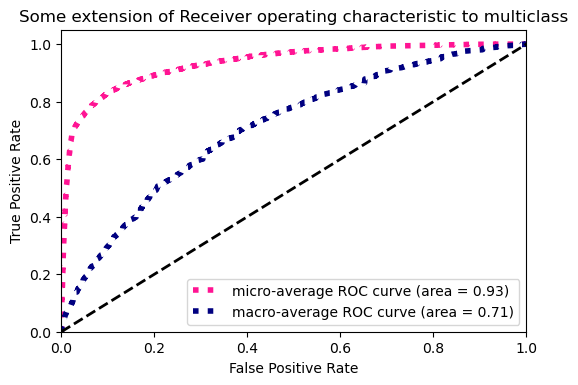

In [9]:
y_true = torch.nn.functional.one_hot(running_targets, num_classes=15).cpu().detach().squeeze().numpy()
y_pred = torch.nn.functional.softmax(running_outputs.cpu(), dim=1).detach().numpy()

n_classes = len(target_map)

fpr, tpr = dict(), dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(dpi=100)
plt.plot(fpr["micro"],
         tpr["micro"],
         label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
         color="deeppink",
         linestyle=":",
         linewidth=4)

plt.plot(fpr["macro"],
         tpr["macro"],
         label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
         color="navy",
         linestyle=":",
         linewidth=4)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

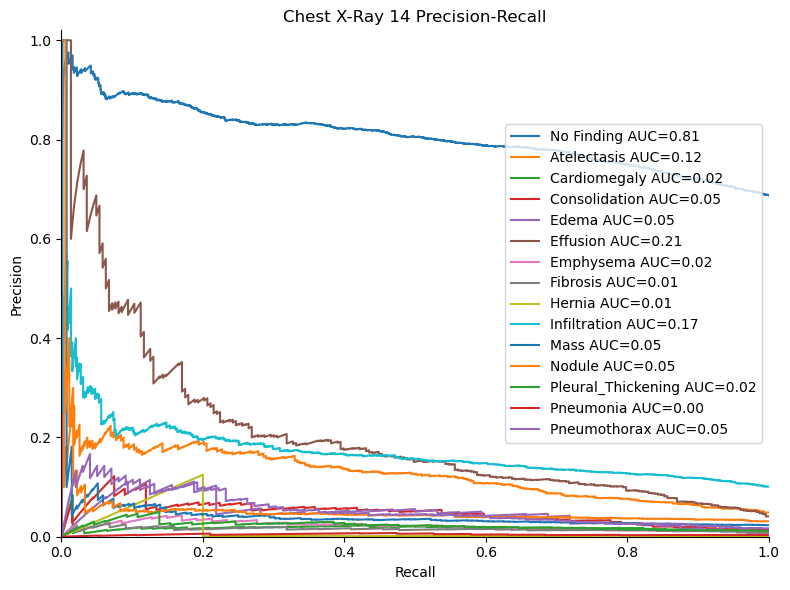

In [10]:
y_true = torch.nn.functional.one_hot(running_targets, num_classes=15).cpu().detach().squeeze().numpy()
y_pred = torch.nn.functional.softmax(running_outputs.cpu(), dim=1).detach().numpy()

scale_factor = 1.25

fig = plt.figure(dpi=100, figsize=(6.4*scale_factor, 4.8*scale_factor))

for i, target in enumerate(target_map):
    precision, recall, _ = metrics.precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc = metrics.auc(recall, precision)
    plt.plot(recall, precision, label=f'{target} AUC={auc:.2f}')
    
plt.xlim(0, 1)
plt.ylim(0, 1.02)

plt.title('Chest X-Ray 14 Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='right')
fig.tight_layout()
plt.show()

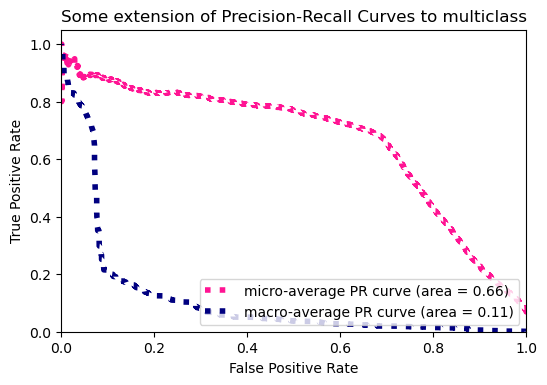

In [11]:
y_true = torch.nn.functional.one_hot(running_targets, num_classes=15).cpu().detach().squeeze().numpy()
y_pred = torch.nn.functional.softmax(running_outputs.cpu(), dim=1).detach().numpy()

n_classes = len(target_map)

recall, precision = dict(), dict()
auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc[i] = metrics.auc(recall[i], precision[i])
    
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_true.ravel(), y_pred.ravel())
auc["micro"] = metrics.auc(recall["micro"], precision["micro"])

# First aggregate all precision
all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_recall = np.zeros_like(all_precision)
for i in range(n_classes):
    mean_recall += np.interp(all_precision, precision[i], recall[i])

# Finally average it and compute AUC
mean_recall /= n_classes

precision["macro"] = all_precision
recall["macro"] = mean_recall
auc["macro"] = metrics.auc(recall["macro"], precision["macro"])

# Plot all ROC curves
plt.figure(dpi=100)
plt.plot(recall["micro"],
         precision["micro"],
         label="micro-average PR curve (area = {0:0.2f})".format(auc["micro"]),
         color="deeppink",
         linestyle=":",
         linewidth=4)

plt.plot(recall["macro"],
         precision["macro"],
         label="macro-average PR curve (area = {0:0.2f})".format(auc["macro"]),
         color="navy",
         linestyle=":",
         linewidth=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Precision-Recall Curves to multiclass")
plt.legend(loc="lower right")
plt.show()

In [12]:
bbox_df['target'].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: target, dtype: int64

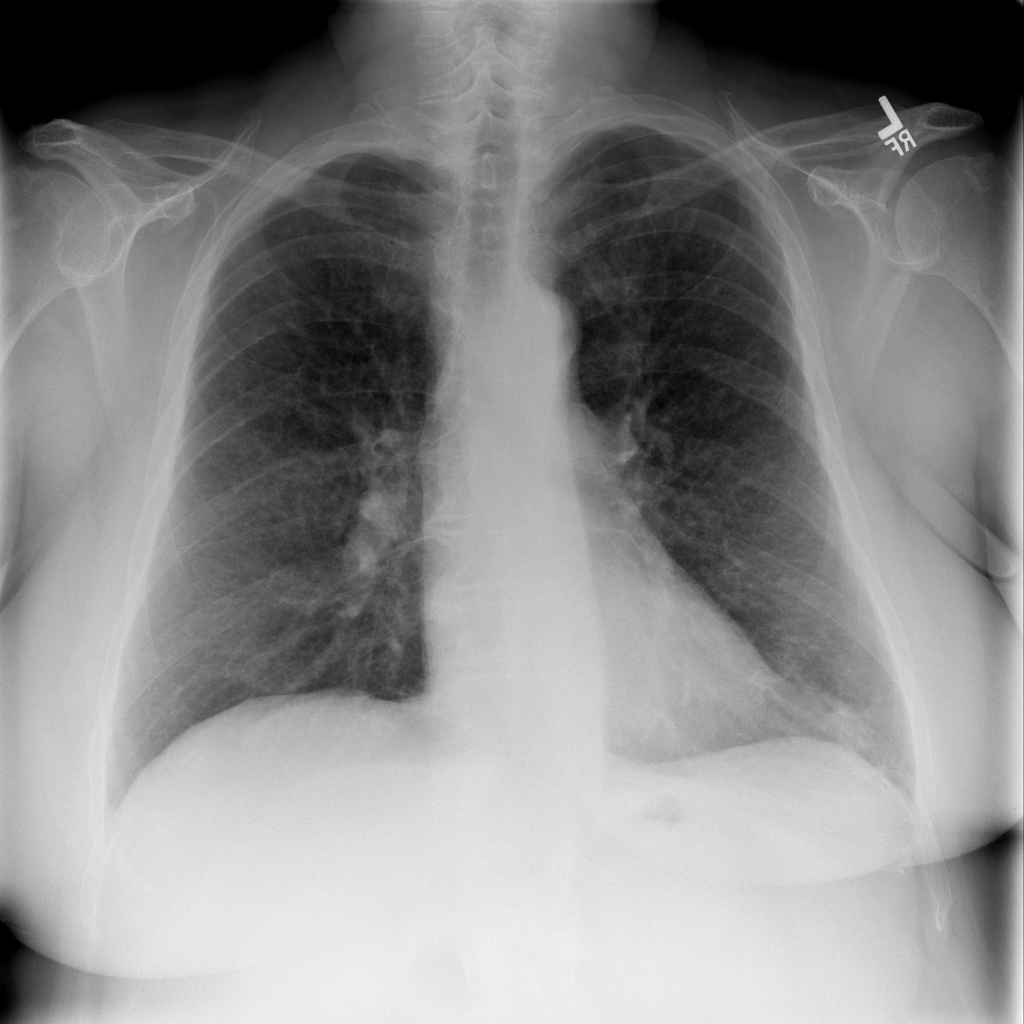

In [13]:
pt = df_test[df_test.target == 14].iloc[3]

img_path = os.path.join(img_dir, pt.file_path)

img = Image.open(img_path).convert("RGB")
# shape = [(pt.x, pt.y), (pt.x + pt.w, pt.y + pt.h)]
# img1 = ImageDraw.Draw(img)
# img1.rectangle(shape, outline ="red")

img.show()